__`NOTEBOOK START`__

In [228]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np 

import plotly.express as px 
import plotly.graph_objects as go

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

--------

# <center>__I - EXPLORATORY DATA ANALYSIS__</center>

--------

In [229]:
print('>>>> 📊 Loading train dataset...')
df = pd.read_csv('conversion_data_train.csv')
print('>>>> ✅ ...Done')

>>>> 📊 Loading train dataset...
>>>> ✅ ...Done


In [230]:
print()
print('Display of dataset: ')
print()
display(df.head(11))

print()
print('Main statistics: ')
print()
df_stats = df.describe().apply(lambda s: s.apply('{0:.2f}'.format))
display(df_stats)

print()
print ('Missing values:')
print()
# Here I created a function that will return the percentage and the quantity of missing values in our DF
def missing_values():
    
    missing = (pd.DataFrame(df.isnull().sum()/df.shape[0])*100).round(2)
    missing.columns = ['Percentage of Missing Values']
    missing['Number of Missing Values'] = pd.DataFrame(df.isnull().sum())
    
    return missing.sort_values(by='Percentage of Missing Values', ascending=False)

display(missing_values())


Display of dataset: 



,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0
5,US,29,0,Seo,7,0
6,US,30,1,Direct,4,0
7,UK,38,1,Ads,2,0
8,UK,26,1,Seo,4,0
9,UK,31,0,Seo,5,0



Main statistics: 



,age,new_user,total_pages_visited,converted
count,284580.00,284580.00,284580.00,284580.00
mean,30.56,0.69,4.87,0.03
std,8.27,0.46,3.34,0.18
min,17.00,0.00,1.00,0.00
25%,24.00,0.00,2.00,0.00
50%,30.00,1.00,4.00,0.00
75%,36.00,1.00,7.00,0.00
max,123.00,1.00,29.00,1.00



Missing values:



,Percentage of Missing Values,Number of Missing Values
country,0.0,0
age,0.0,0
new_user,0.0,0
source,0.0,0
total_pages_visited,0.0,0
converted,0.0,0


In [231]:
df.columns.tolist()

['country', 'age', 'new_user', 'source', 'total_pages_visited', 'converted']

In [232]:
rows = df.shape[0]
columns = df.shape[1]
number_of_elements = df.size

print()
print ('Our data frame shape:')
print (f' - Number of columns/features: {columns}')
print (f' - Number of rows: {rows}')
print (f' - Number of elements: {number_of_elements}')


Our data frame shape:
 - Number of columns/features: 6
 - Number of rows: 284580
 - Number of elements: 1707480


In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


In [234]:
df.nunique()

country                 4
age                    60
new_user                2
source                  3
total_pages_visited    29
converted               2
dtype: int64

In [235]:
# remove outliners in the column 'age'
df = df.loc[df['age'] < (df['age'].mean())+(df['age'].std()*3)]

In [236]:
# converting thoose variables to categorical
df['new_user'] = pd.Categorical(df.new_user)
df['converted'] = pd.Categorical(df.converted)

In [237]:
fig_number = 0

# columns we will plot
columns = ['country', 'age', 'new_user', 'source', 'total_pages_visited', 'converted']

for column in columns: 

        fig_number += 1
        fig_number_updated = fig_number
        
        df_grouped = df.groupby(column).size().reset_index(name='count')

        fig = px.bar(df_grouped, x=column, y='count')

        fig.update_layout(
                height=650,
                title=f'<b>{column.upper()} Column Bar Chart</b> - <i>fig.{fig_number_updated}</i>',
                title_font={"size": 20},
                xaxis_tickfont_size=14,
                yaxis_tickfont_size=14,
                xaxis={'title': column.upper(), 'title_font': {'size': 16}},
                yaxis={'title': 'COUNT', 'title_font': {'size': 16}}
                )

        fig.show()

__FIGURES INTERPRETATION:__<br><br>

* fig.1: We have 4 countries in this data set, China, Germany, US and UK. The United States is over represented in this data set.

* fig.2: Age distribution goes from 15 years to 55 years old. Most users are young. 

* fig.3: Most users are new users. 

* fig.4: We have 3 sources, Ads, SEO, and Direct and most users are coming thanks to SEO. 

* fig.5: Most users are visiting between 1 to 10 pages. 

* fig.6: Most visitors have not been converted to buyers.

--------

# <center>__II - PREPROCESSING__</center>

--------

In [238]:
print('>>>> 💔 Separating labels from features...')

features_list = ['country', 'age', 'new_user','source', 'total_pages_visited']
target_variable = 'converted'

# all rows of the list of columns definied
X = df.loc[:, features_list]

# all rows of the definied target variable
Y = df.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print('>>>> ✅ ...Done')

>>>> 💔 Separating labels from features...
Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')
>>>> ✅ ...Done


In [239]:
print('>>>> 🟨 Dividing into train and test sets...')

# Dividing the dataset into Train & Test sets 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=0)

print('>>>> ✅ ...Done')

>>>> 🟨 Dividing into train and test sets...
>>>> ✅ ...Done


In [240]:
print('>>>> 🟨 Creating pipeline for numeric & categorical features...')

# Detecting numeric and categorical features of our dataset
numeric_features = []
categorical_features = []

for i,t in X.dtypes.iteritems():
        if ('float' in str(t)) or ('int' in str(t)) :
            numeric_features.append(i)
        else :
            categorical_features.append(i)
    
print('Numeric features found: ', numeric_features)
print('Categorical features found: ', categorical_features)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test) 

print('>>>> ✅ ...Done')

>>>> 🟨 Creating pipeline for numeric & categorical features...
Numeric features found:  ['age', 'total_pages_visited']
Categorical features found:  ['country', 'new_user', 'source']


C:\Users\zouao\AppData\Local\Temp\ipykernel_22644\4190040723.py:7: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



>>>> ✅ ...Done


--------

# <center>__III - BASELINE MODEL: LOGISTIC REGRESSION__</center>

--------

#### __SECTION PLAN__ 🎯

1. MODEL TRAINNING AND PREDICTIONS
2. EVALUATING THE MODEL: PERFORMANCE METRICS, CONFUSION MATRIX & ROC CURVES


--------
### __1. MODEL TRAINNING AND PREDICTIONS__
--------

In [241]:
print('>>>> 🟨 Trainning model...')

classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

print('>>>> ✅ ...Done')


>>>> 🟨 Trainning model...
>>>> ✅ ...Done


In [242]:
print('>>>> 🟨 Predictions results on training & test sets...')

Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)

print('>>>> ✅ ...Done')

>>>> 🟨 Predictions results on training & test sets...
>>>> ✅ ...Done


--------
### __2. EVALUATING THE MODEL: PERFORMANCE METRICS, CONFUSION MATRIX & ROC CURVES__
--------

In [243]:
print('f1-score on train set: ', f1_score(Y_train, Y_train_pred))
print('f1-score on test set: ', f1_score(Y_test, Y_test_pred))

f1-score on train set:  0.7642557842958646
f1-score on test set:  0.7649260381393691


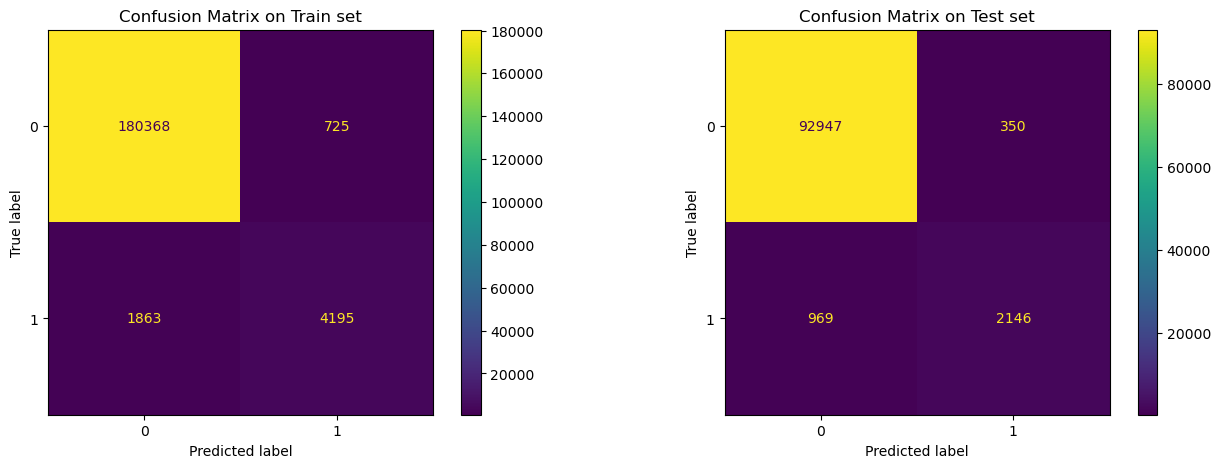

In [244]:
# Visualize confusion matrices
# Get subplot from matplotlib
fig , ax = plt.subplots(1, 2, figsize = (16, 5))
# Setting the title
ax[0].set(title="Confusion Matrix on Train set")
# ConfusionMatrixDisplay from sklearn for Train set
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax[0]) 

# Confusion Matrix for test set
ax[1].set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax[1])
plt.show()

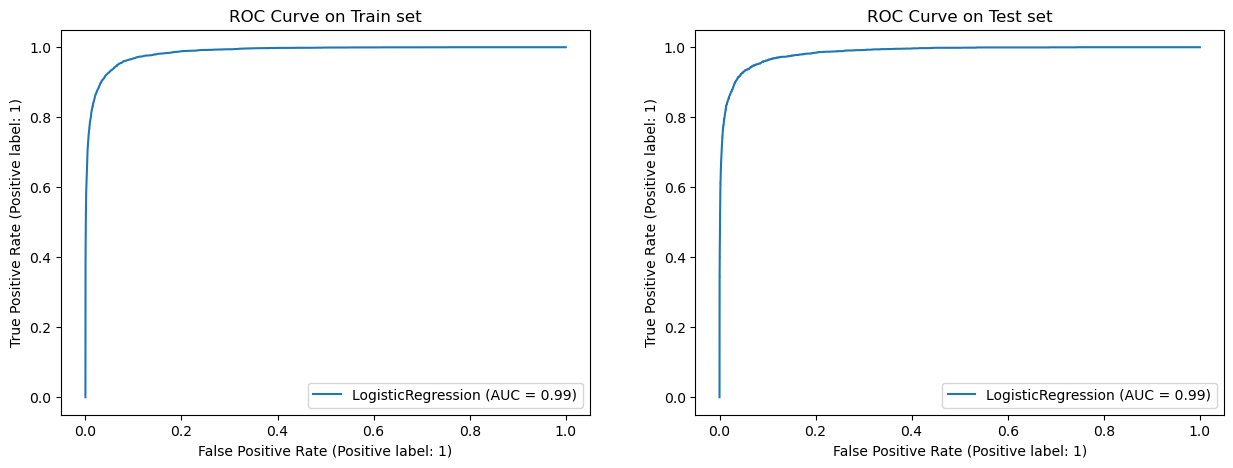

In [245]:
# Visualize ROC curves
fig , ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_train, Y_train, ax=ax[0]) # RocCurveDisplay from sklearn

ax[1].set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax[1]) # RocCurveDisplay from sklearn
plt.show()

In [246]:
actual_vs_predicted_results = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_test_pred})
actual_vs_predicted_results.head(10)

,Actual,Predicted
84609,0,0
283081,0,0
277522,0,0
69706,0,0
185040,0,0
186448,1,1
161530,0,0
263903,0,0
153802,0,0
79124,0,0


__OBSERVATIONS:__<br>
* The base model give us a good f1 score at around 0.764 for both train and test sets.

* The most influencial twick made was playing with the size of our test set with the best size being 0.34 to give us the highest and most equal final f1 score without overfitting or underfitting.


--------

# <center>__IV -DECISION TREE__</center>

--------

#### __SECTION PLAN__ 🎯

1. DECISION TREE
2. EVALUATING THE MODEL: PERFORMANCE METRICS, CONFUSION MATRIX & ROC CURVES
3. GRADIENT BOOSTING WITH DECISION TREE AS BASE ESTIMATOR
4. EVALUATING THE MODEL: PERFORMANCE METRICS, CONFUSION MATRIX & ROC CURVES



--------
### __1. DECISION TREE__
--------

In [247]:
# Perform grid search
print('>>>> 🕵️‍♂️ Grid search...')

decision_tree = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6], 
    'min_samples_leaf': [1, 2, 5], 
    'min_samples_split': [2, 4, 8], 
}

gridsearch = GridSearchCV(decision_tree, param_grid = params, cv = 5, scoring = 'f1') # cv : the number of folds to be used for CV

gridsearch.fit(X_train, Y_train)

print('>>>> ✅ ...Done')


>>>> 🕵️‍♂️ Grid search...
>>>> ✅ ...Done


In [248]:
print('Grid values tested: ', params)
print('----------------------')
print('DECISION TREE RESULTS: ')
print(' - Best hyperparameters: ', gridsearch.best_params_)
print(' - Best validation accuracy: ', gridsearch.best_score_)

Grid values tested:  {'max_depth': [2, 4, 6], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 4, 8]}
----------------------
DECISION TREE RESULTS: 
 - Best hyperparameters:  {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}
 - Best validation accuracy:  0.7359164698340159


In [249]:
Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

--------
### __2. EVALUATING THE MODEL: PERFORMANCE METRICS, CONFUSION MATRIX & ROC CURVES__
--------

In [250]:
print('f1-score on train set: ', f1_score(Y_train, Y_train_pred))
print('f1-score on test set: ', f1_score(Y_test, Y_test_pred))

f1-score on train set:  0.7480860371855633
f1-score on test set:  0.7452579329906044


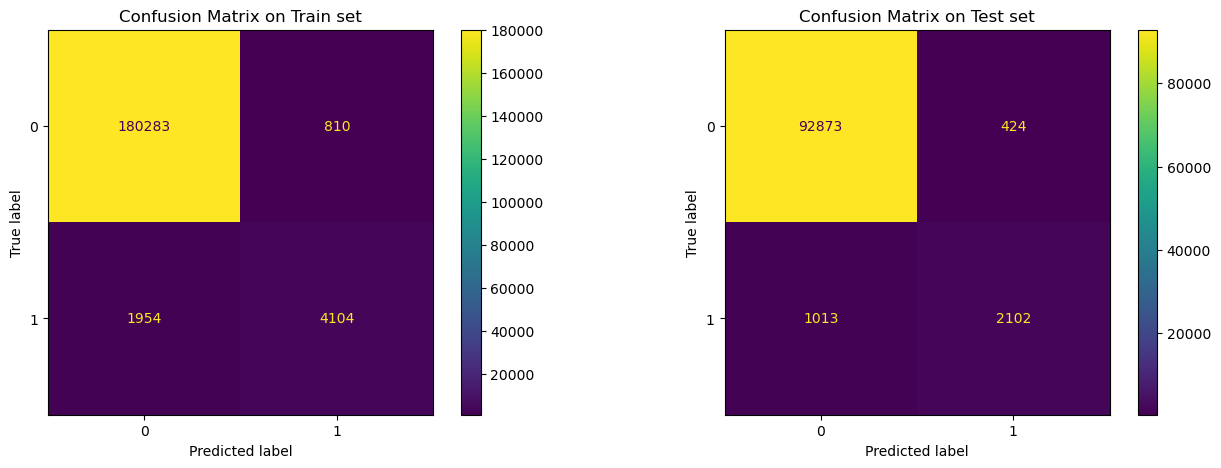

In [251]:
# Visualize confusion matrices
# Get subplot from matplotlib
fig , ax = plt.subplots(1, 2, figsize = (16, 5))
# Setting the title
ax[0].set(title="Confusion Matrix on Train set")
# ConfusionMatrixDisplay from sklearn for Train set
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax[0]) 

# Confusion Matrix for test set
ax[1].set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax[1])
plt.show()

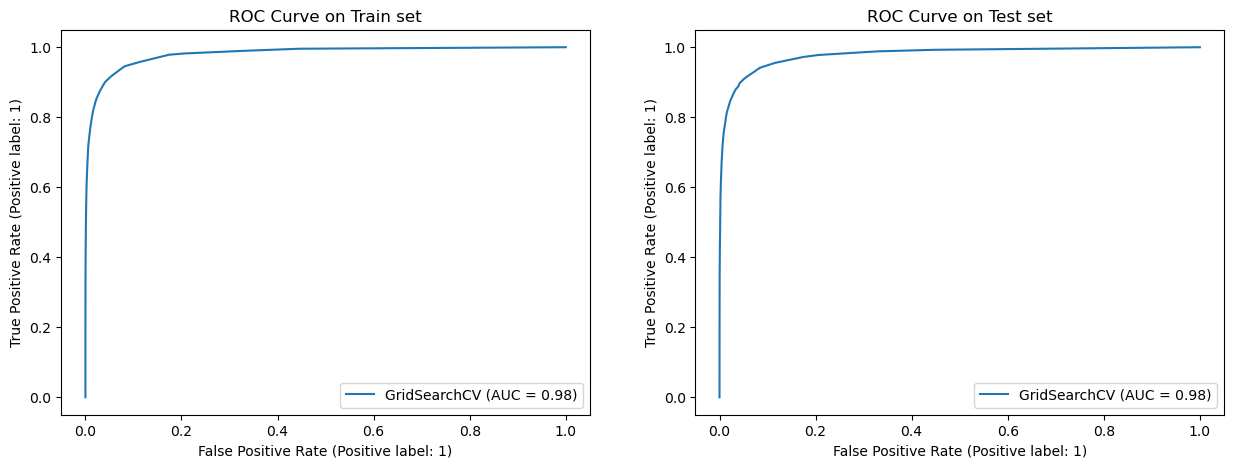

In [252]:
# Visualize ROC curves
fig , ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax[0]) # RocCurveDisplay from sklearn

ax[1].set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax[1]) # RocCurveDisplay from sklearn
plt.show()

__OBSERVATIONS:__<br>
* The Decision Tree model gave us an f1 score at around 0.74. 

* We have similar results for the confusion matrix

--------
### __3. GRADIENT BOOSTING WITH DECISION TREE AS BASE ESTIMATOR__
--------

In [253]:
# Perform grid search
print('>>>> 🕵️‍♂️ Grid search...')

model = GradientBoostingClassifier()

# Grid of values to be tested
params = {
    'max_depth': [1, 2, 3], # no base_estimator_ prefix because these are all arguments of GradientBoostingClassifier
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [2, 4, 6, 8, 10]
}

gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV

gridsearch.fit(X_train, Y_train)

print('>>>> ✅ ...Done')


>>>> 🕵️‍♂️ Grid search...
>>>> ✅ ...Done


In [254]:
print('Grid values tested: ', params)
print('----------------------')
print('GRADIENT BOOSTING RESULTS: ')
print(' - Best hyperparameters: ', gridsearch.best_params_)
print(' - Best validation accuracy: ', gridsearch.best_score_)

Grid values tested:  {'max_depth': [1, 2, 3], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
----------------------
GRADIENT BOOSTING RESULTS: 
 - Best hyperparameters:  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
 - Best validation accuracy:  0.9841037447321527


In [255]:
Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

--------
### __4. EVALUATING THE MODEL: PERFORMANCE METRICS, CONFUSION MATRIX & ROC CURVES__
--------

In [256]:
print('f1-score on train set: ', f1_score(Y_train, Y_train_pred))
print('f1-score on test set: ', f1_score(Y_test, Y_test_pred))

f1-score on train set:  0.7213814512999612
f1-score on test set:  0.7226386806596702


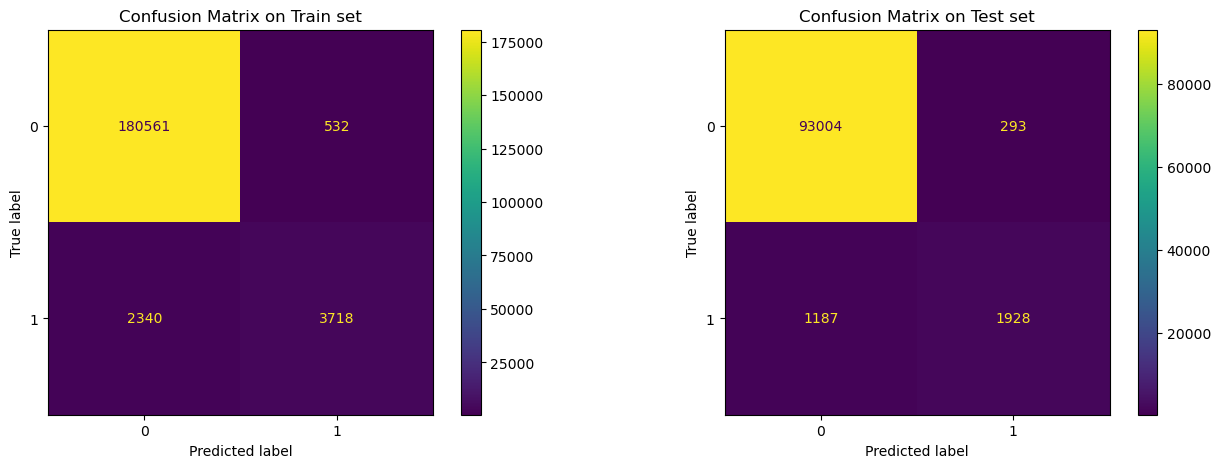

In [257]:
# Visualize confusion matrices
# Get subplot from matplotlib
fig , ax = plt.subplots(1, 2, figsize = (16, 5))
# Setting the title
ax[0].set(title="Confusion Matrix on Train set")
# ConfusionMatrixDisplay from sklearn for Train set
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax[0]) 

# Confusion Matrix for test set
ax[1].set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax[1])
plt.show()

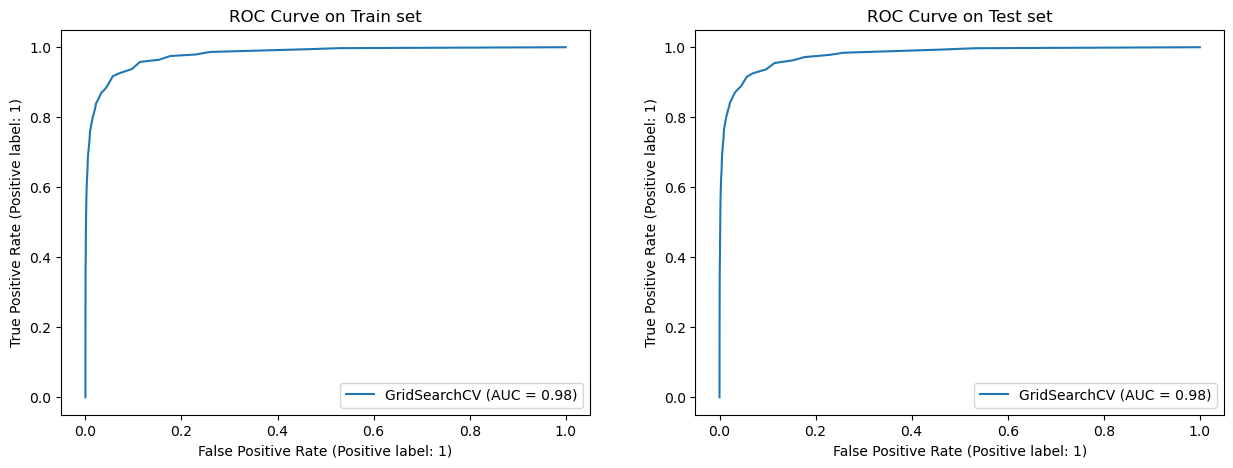

In [258]:
# Visualize ROC curves
fig , ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax[0]) # RocCurveDisplay from sklearn

ax[1].set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax[1]) # RocCurveDisplay from sklearn
plt.show()

__OBSERVATIONS:__<br>
* Gradient boosting with decision tree as the base estimator gave us a F1 score 0.72. 

* It is worth noting that we get the highest False Positives on train set with this model so far.


--------

# <center>__V - RANDOM FOREST__</center>

--------

#### __SECTION PLAN__ 🎯

1. RANDOM FOREST CLASSIFIER
2. EVALUATING THE MODEL: PERFORMANCE METRICS, CONFUSION MATRIX & ROC CURVES



--------
### __1. RANDOM FOREST CLASSIFIER__
--------

In [259]:
print('>>>> 🕵️‍♂️ Grid search...')

model = RandomForestClassifier()

params = {
    'max_depth': [2, 4, 6], 
    'min_samples_leaf': [1, 2, 5], 
    'min_samples_split': [2, 4, 8], 
    'n_estimators': [10, 20, 40]
}

gridsearch = GridSearchCV(model, param_grid=params, cv = 3)

gridsearch.fit(X_train, Y_train)

print('>>>> ✅ ...Done')

>>>> 🕵️‍♂️ Grid search...
>>>> ✅ ...Done


In [260]:
print('Grid values tested: ', params)
print('----------------------')
print('RANDOM FOREST RESULTS: ')
print(' - Best hyperparameters: ', gridsearch.best_params_)
print(' - Best validation accuracy: ', gridsearch.best_score_)

Grid values tested:  {'max_depth': [2, 4, 6], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 4, 8], 'n_estimators': [10, 20, 40]}
----------------------
RANDOM FOREST RESULTS: 
 - Best hyperparameters:  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 40}
 - Best validation accuracy:  0.9852418622077902


In [261]:
Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

--------
### __2. EVALUATING THE MODEL: PERFORMANCE METRICS, CONFUSION MATRIX & ROC CURVES__
--------

In [262]:
print('f1-score on train set: ', f1_score(Y_train, Y_train_pred))
print('f1-score on test set: ', f1_score(Y_test, Y_test_pred))

f1-score on train set:  0.7323916220165612
f1-score on test set:  0.7320583222874457


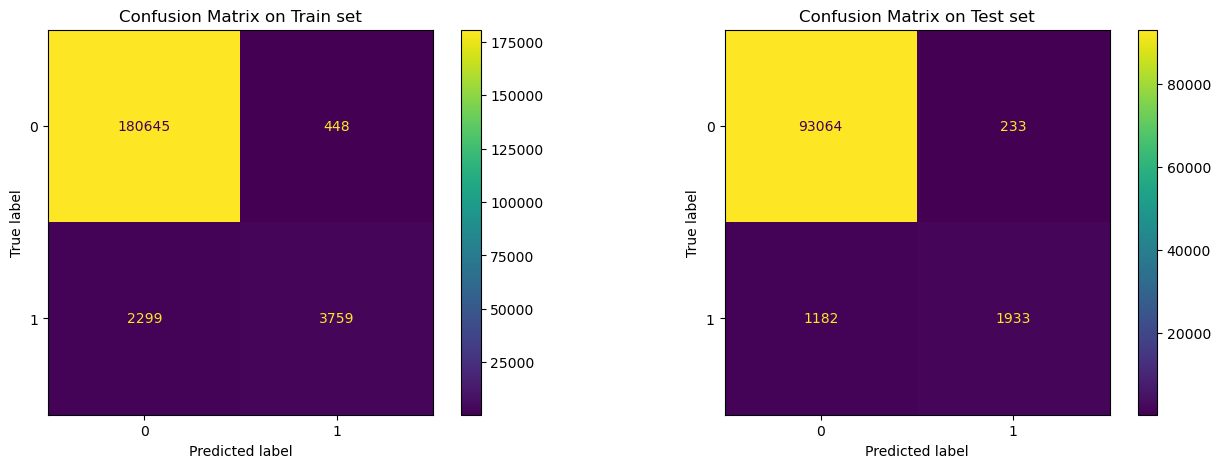

In [263]:
# Visualize confusion matrices
# Get subplot from matplotlib
fig , ax = plt.subplots(1, 2, figsize = (16, 5))
# Setting the title
ax[0].set(title="Confusion Matrix on Train set")
# ConfusionMatrixDisplay from sklearn for Train set
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax[0]) 

# Confusion Matrix for test set
ax[1].set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax[1])
plt.show()

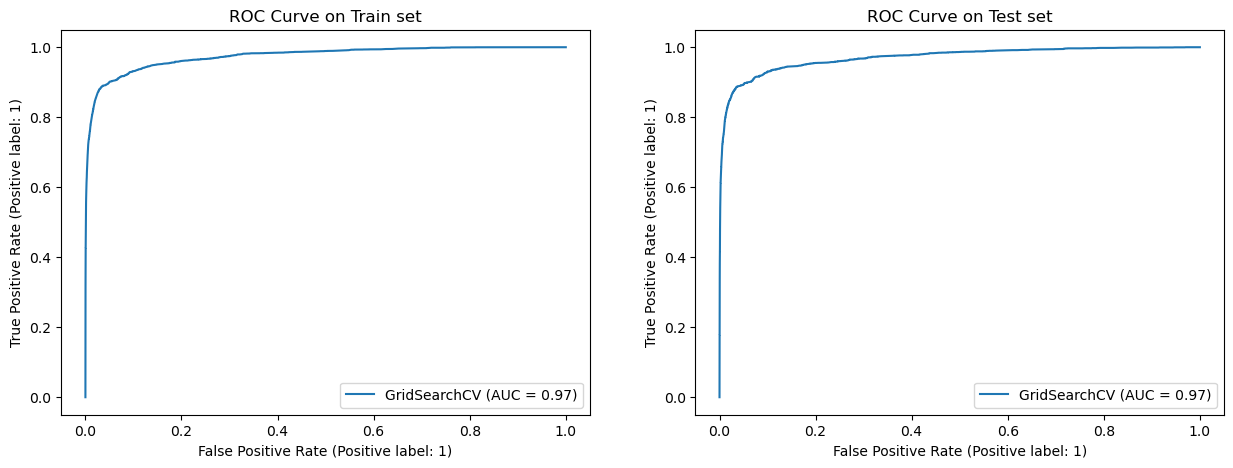

In [264]:
# Visualize ROC curves
fig , ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax[0]) # RocCurveDisplay from sklearn

ax[1].set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax[1]) # RocCurveDisplay from sklearn
plt.show()

__OBSERVATIONS:__<br>
* The random forest give us one of the lowest score at around 0.72.

* The most influencial twick made were playing with the size of our test set with the best size being 0.34 to give us the highest and most equal finals f1 score without creating under of overfitting.

* Again, this result in high False Positives.


--------

# <center>__VI - XGBoost__</center>

--------

#### __SECTION PLAN__ 🎯

1. XGB BOOST CLASSIFIER
2. EVALUATING THE MODEL: PERFORMANCE METRICS, CONFUSION MATRIX & ROC CURVES



--------
### __1.  XGB BOOST CLASSIFIER__
--------

In [265]:
# Perform grid search
print('>>>> 🕵️‍♂️ Grid search...')

xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6], # exactly the same role as in scikit-learn
    'min_child_weight': [1, 2, 3], # effect is more or less similar to min_samples_leaf and min_samples_split
    'n_estimators': [2, 4, 6, 8,] # exactly the same role as in scikit-learn
}

gridsearch = GridSearchCV(xgboost, param_grid = params, cv = 3) # cv : the number of folds to be used for CV

gridsearch.fit(X_train, Y_train)

print('>>>> ✅ ...Done')

>>>> 🕵️‍♂️ Grid search...
>>>> ✅ ...Done


In [266]:
print('Grid values tested: ', params)
print('----------------------')
print('XGBOOST RESULTS: ')
print(' - Best hyperparameters: ', gridsearch.best_params_)
print(' - Best validation accuracy: ', gridsearch.best_score_)

Grid values tested:  {'max_depth': [2, 4, 6], 'min_child_weight': [1, 2, 3], 'n_estimators': [2, 4, 6, 8]}
----------------------
XGBOOST RESULTS: 
 - Best hyperparameters:  {'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 8}
 - Best validation accuracy:  0.9856532953155863


In [267]:
Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

--------
### __2. EVALUATING THE MODEL: PERFORMANCE METRICS, CONFUSION MATRIX & ROC CURVES__
--------

In [268]:
print('f1-score on train set: ', f1_score(Y_train, Y_train_pred))
print('f1-score on test set: ', f1_score(Y_test, Y_test_pred))

f1-score on train set:  0.758046614872364
f1-score on test set:  0.7560931576096769


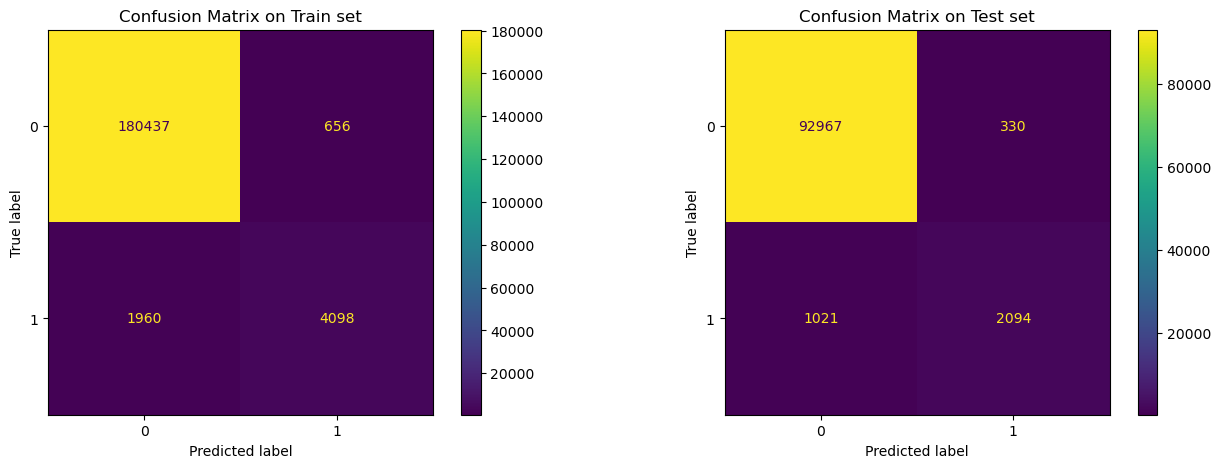

In [269]:
# Visualize confusion matrices
# Get subplot from matplotlib
fig , ax = plt.subplots(1, 2, figsize = (16, 5))
# Setting the title
ax[0].set(title="Confusion Matrix on Train set")
# ConfusionMatrixDisplay from sklearn for Train set
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax[0]) 

# Confusion Matrix for test set
ax[1].set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax[1])
plt.show()

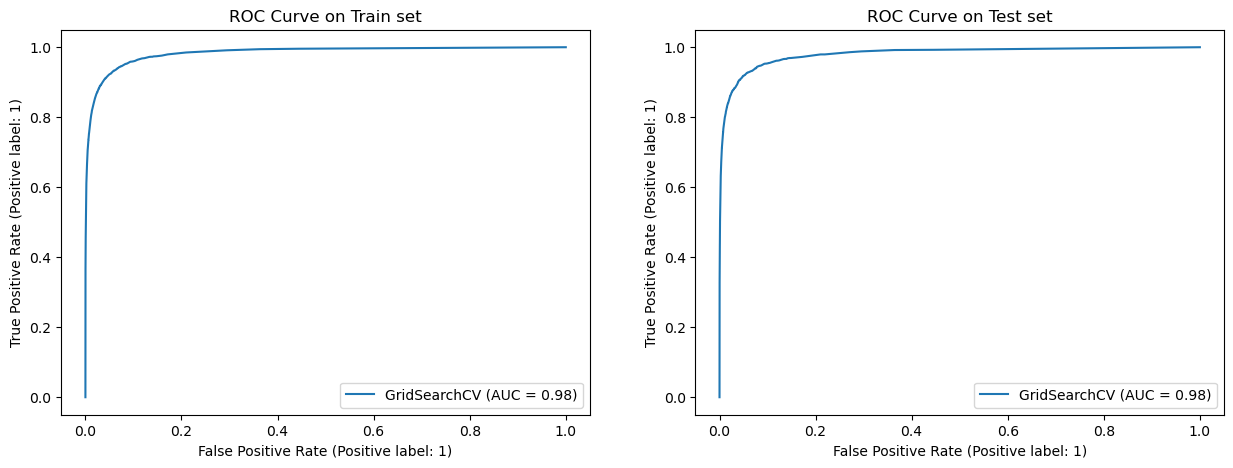

In [270]:
# Visualize ROC curves
fig , ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax[0]) # RocCurveDisplay from sklearn

ax[1].set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax[1]) # RocCurveDisplay from sklearn
plt.show()

__OBSERVATIONS:__<br>
* We have a score at around 0.756 with this last model. 



--------

# <center>__VII - CONCATENATE ALL SETS TO TRAIN THE MODEL__</center>

--------

In [271]:
X = np.append (X_train, X_test, axis = 0)
Y = np.append (Y_train, Y_test)

In [272]:
classifier.fit(X, Y)

LogisticRegression()

In [273]:
prediction = classifier.predict(X)

In [274]:
print('f1-score on all sets: ', f1_score(Y, prediction))

f1-score on all sets:  0.7635902391882097


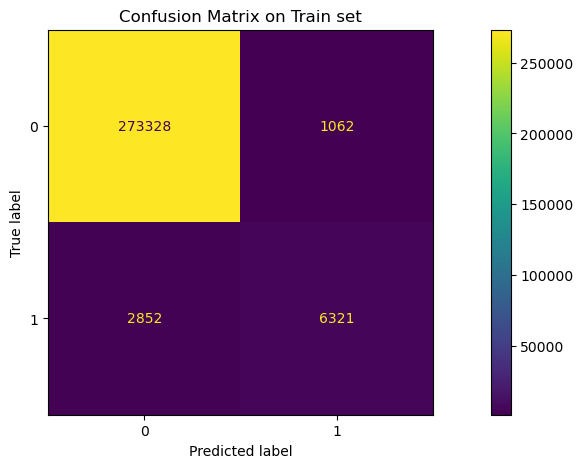

In [275]:
# Visualize confusion matrices
_ , ax = plt.subplots(figsize = (15, 5)) # Get subplot from matplotlib
ax.set(title='Confusion Matrix on Train set') # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X, Y, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

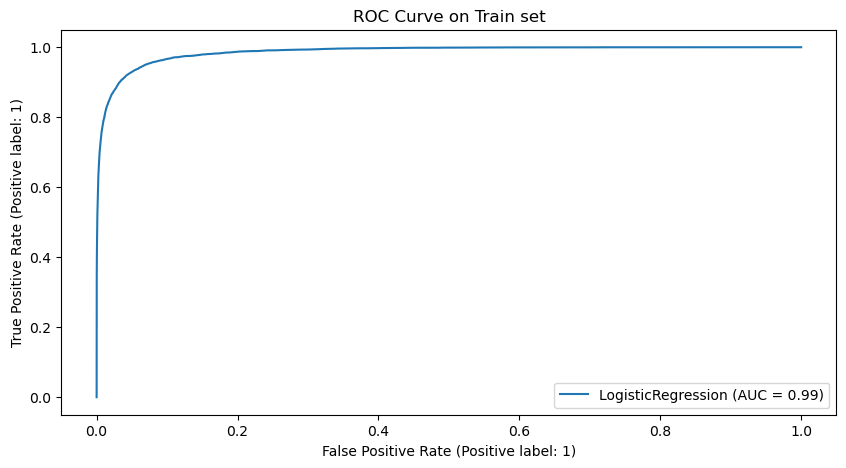

In [276]:
# Visualize ROC curves
_ , ax = plt.subplots(figsize = (10, 5)) # Get subplot from matplotlib
ax.set(title='ROC Curve on Train set') # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X, Y, ax=ax) # RocCurveDisplay from sklearn
plt.show()


__OBSERVATIONS:__<br>
* The base model give us a good f1 score at around 0.76 for both train and test sets.


--------

# <center>__VIII - PREDICTIONS ON DATA TEST__</center>

--------

In [277]:
df_test = pd.read_csv('conversion_data_test.csv')

In [278]:
df_test.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [279]:
X = df_test

In [280]:
X = preprocessor.transform(X) 

In [281]:
data = {
    'Converted': classifier.predict(X)
} 

Y = pd.DataFrame(columns=['Converted'], data = data)

Y.to_csv('Conversion_Predictions_Using_Data_Test.csv', index = False)

__`NOTEBOOK END`__